# Example: Convolutional Neural Networks

Before runnning this notebook, make sure that all neccesary libraries are installed:

In [80]:
using Flux
using Plots
using JuMP
using Gurobi
using Random
using Gogeta
using Images
using FileIO

Suppose we have a trained CNN with some weights and we would like to formulate it as a MIP problem. In our case we generate it with random weights:

In [81]:
Random.seed!(1234)
CNN_model = Flux.Chain(
    Conv((4,3), 1 => 10, pad=(2, 1), stride=(3, 2), relu),
    MeanPool((5,3), pad=(3, 2), stride=(2, 2)),
    MaxPool((3,4), pad=(1, 3), stride=(3, 2)),
    Conv((4,3), 10 => 5, pad=(2, 1), stride=(3, 2), relu),
    MaxPool((3,4), pad=(1, 3), stride=(3, 2)),
    Flux.flatten,
    Dense(20 => 100, relu),
    Dense(100 => 1)
)

Chain(
  Conv((4, 3), 1 => 10, relu, pad=(2, 1), stride=(3, 2)),  # 130 parameters
  MeanPool((5, 3), pad=(3, 2), stride=2),
  MaxPool((3, 4), pad=(1, 3), stride=(3, 2)),
  Conv((4, 3), 10 => 5, relu, pad=(2, 1), stride=(3, 2)),  # 605 parameters
  MaxPool((3, 4), pad=(1, 3), stride=(3, 2)),
  Flux.flatten,
  Dense(20 => 100, relu),               # 2_100 parameters
  Dense(100 => 1),                      # 101 parameters
)                   # Total: 8 arrays, 2_936 parameters, 12.609 KiB.

At first lets import some sample image:

In [82]:
image = load("needed_files/example_image.png"); 
downscaled_image = imresize(image, (70, 50));
input = reshape(Float32.(channelview(Gray.(downscaled_image))), 70, 50, 1, 1);
input = input[end:-1:1, :, :, :];

The input looks as follows:

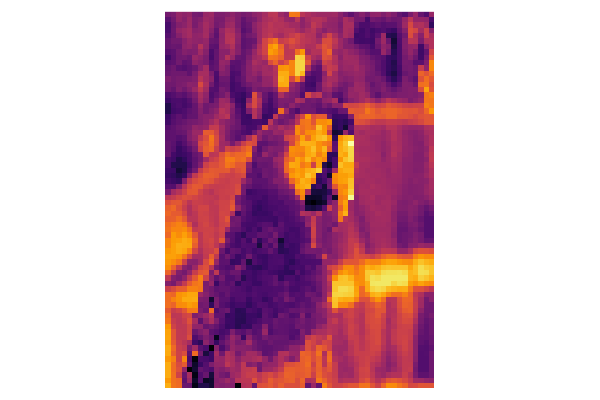

In [83]:
# input image
heatmap(input[:, :, 1, 1], background=false, legend=false, color=:inferno, aspect_ratio=:equal, axis=([], false))

Now at each layer CNN produces different images with different properties and sizes and we want to replicate the output of each layer with a MIP. For now on, lets look at outputs of CNN at each layer.

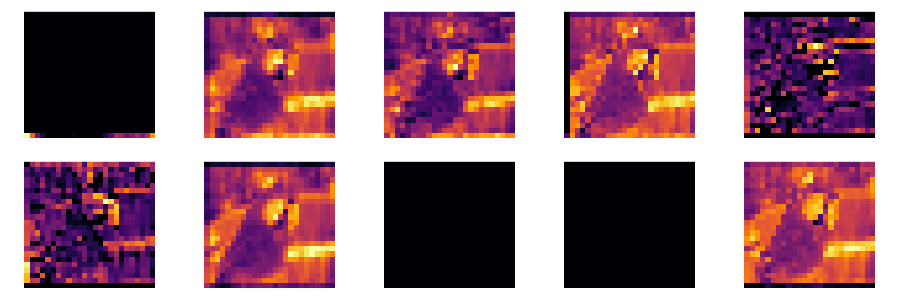

In [84]:
# convolution layer outputs
outputs = [CNN_model[1](input)[:, :, channel, 1] for channel in 1:10];
heatmaps = [heatmap(outputs[i], background=false, legend=false, color=:inferno, aspect_ratio=:equal, axis=([], false)) for i in 1:10]
plot(heatmaps..., layout=(2, 5), size=(900, 300))

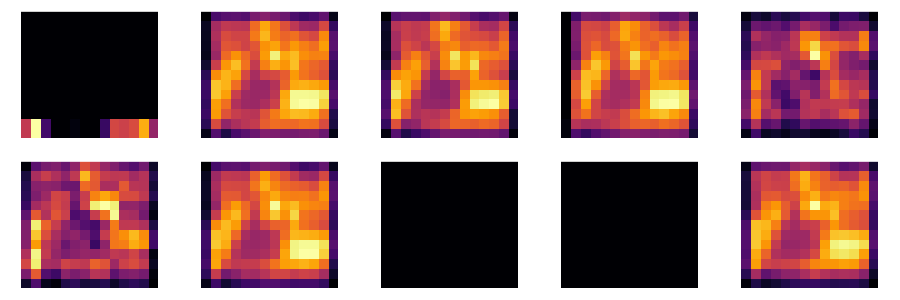

In [85]:
# meanpool outputs
outputs = [CNN_model[1:2](input)[:, :, channel, 1] for channel in 1:10];
heatmaps = [heatmap(outputs[i], background=false, legend=false, color=:inferno, aspect_ratio=:equal, axis=([], false)) for i in 1:10]
plot(heatmaps..., layout=(2, 5), size=(900, 300))

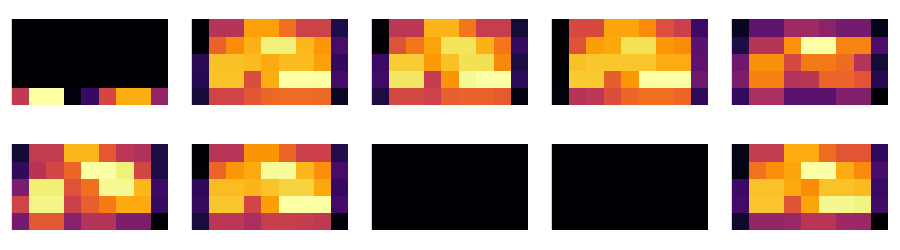

In [86]:
# maxpool
outputs = [CNN_model[1:3](input)[:, :, channel, 1] for channel in 1:10];
heatmaps = [heatmap(outputs[i], background=false, legend=false, color=:inferno, aspect_ratio=:equal, axis=([], false)) for i in 1:10]
plot(heatmaps..., layout=(2, 5), size=(900, 250))

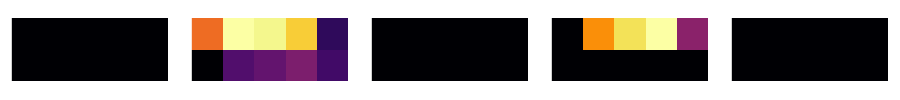

In [87]:
# new conv
outputs = [CNN_model[1:4](input)[:, :, channel, 1] for channel in 1:5];
heatmaps = [heatmap(outputs[i], background=false, legend=false, color=:inferno, aspect_ratio=:equal, axis=([], false)) for i in 1:5]
plot(heatmaps..., layout=(1, 5), size=(900, 100))

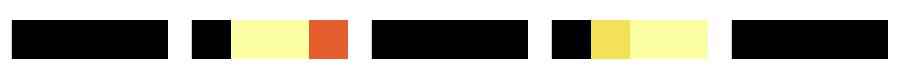

In [88]:
# last maxpool
outputs = [CNN_model[1:5](input)[:, :, channel, 1] for channel in 1:5];
heatmaps = [heatmap(outputs[i], background=false, legend=false, color=:inferno, aspect_ratio=:equal, axis=([], false)) for i in 1:5]
plot(heatmaps..., layout=(1, 5), size=(900, 80))

To formulate CNN as a MIP problem, you need to call `get_structure()` function with input parameters: CNN_model and input image to get all neccessary information about the problem. 

Then, you need to call `CNN_formulate!()` with input arguments: jump (innitialized empty model), CNN and information about strcututr of CNN 

In [71]:
# create jump model from cnn
jump = Model(Gurobi.Optimizer)
set_silent(jump)
cnns = get_structure(CNN_model, input);
CNN_formulate!(jump, CNN_model, cnns)

Set parameter Username
Academic license - for non-commercial use only - expires 2025-05-20
Formulating CNN as JuMP model...
Preprocessing completed
Added conv layer
Added meanpool layer
Added maxpool layer
Added conv layer
Added maxpool layer
Added flatten layer
Added dense layer
Added dense layer
Formulation complete.


(Dict{Int64, Dict}(0 => Dict((20, 14, 1) => 1.0, (11, 8, 1) => 1.0, (69, 8, 1) => 1.0, (65, 46, 1) => 1.0, (47, 15, 1) => 1.0, (20, 16, 1) => 1.0, (14, 12, 1) => 1.0, (24, 31, 1) => 1.0, (26, 22, 1) => 1.0, (4, 7, 1) => 1.0…), 4 => Dict((1, 2, 3) => 1.1909818861181132, (1, 3, 5) => 1.4841436383974842, (2, 5, 3) => 1.7680811302935169, (1, 4, 5) => 1.4841436383974842, (2, 1, 1) => 1.2953315250234436, (1, 3, 2) => 1.8113779673855743, (1, 4, 2) => 1.8113779673855743, (2, 2, 1) => 3.664044116994194, (1, 1, 5) => 0.6287132026416157, (1, 2, 5) => 1.4841436383974842…), 5 => Dict((1, 2, 1) => 3.664044116994194, (1, 3, 4) => 3.867979382243537, (1, 2, 5) => 3.7049730533754452, (1, 4, 4) => 3.867979382243537, (1, 3, 1) => 3.664044116994194, (1, 2, 3) => 3.428607284199104, (1, 1, 2) => 1.576238649129576, (1, 3, 5) => 3.7049730533754452, (1, 4, 1) => 3.664044116994194, (1, 4, 5) => 3.7049730533754452…), 2 => Dict((10, 1, 8) => 0.044903770089149475, (11, 8, 1) => 0.35975046269595623, (12, 1, 9) => 0.

Now we have a jump model with constraints and variables that produces the same output as CNN

In [72]:
jump

A JuMP Model
Maximization problem with:
Variables: 29901
Objective function type: AffExpr
`AffExpr`-in-`MathOptInterface.EqualTo{Float64}`: 8461 constraints
`AffExpr`-in-`MathOptInterface.GreaterThan{Float64}`: 5740 constraints
`AffExpr`-in-`MathOptInterface.LessThan{Float64}`: 17940 constraints
`AffExpr`-in-`MathOptInterface.Interval{Float64}`: 3500 constraints
`VariableRef`-in-`MathOptInterface.GreaterThan{Float64}`: 17990 constraints
`VariableRef`-in-`MathOptInterface.ZeroOne`: 11790 constraints
Model mode: AUTOMATIC
CachingOptimizer state: EMPTY_OPTIMIZER
Solver name: Gurobi
Names registered in the model: c, cs, cz, s, x, z

We can easily check this by calling function `image_pass!(jump, input, cnns, i)`, where `i` is the index of the layer you are interested in.

In [73]:
# Test that jump model produces same outputs for all layers as the CNN
@time println("Conv layer 1, approximately the same = ", CNN_model[1](input)[:, :, :, 1] ≈ image_pass!(jump, input, cnns, 1))
@time println("MeanPool 1, approximately the same = ", CNN_model[1:2](input)[:, :, :, 1] ≈ image_pass!(jump, input, cnns, 2))
@time println("MaxPool 2, approximately the same = ", CNN_model[1:3](input)[:, :, :, 1] ≈ image_pass!(jump, input, cnns, 3))
@time println("Conv layer 2, approximately the same = ", CNN_model[1:4](input)[:, :, :, 1] ≈ image_pass!(jump, input, cnns, 4))
@time println("MaxPool, approximately the same = ", CNN_model[1:5](input)[:, :, :, 1] ≈ image_pass!(jump, input, cnns, 5))
@time println("Flatten, approximately the same = ", vec(CNN_model[1:6](input)) ≈ image_pass!(jump, input, cnns, 6))
@time println("Dense 1, approximately the same = ", vec(CNN_model[1:7](input)) ≈ image_pass!(jump, input, cnns, 7))
@time println("Dense 1, approximately the same = ", vec(CNN_model[1:8](input)) ≈ image_pass!(jump, input, cnns, 8))
@time println("Output, approximately the same = ", vec(CNN_model(input)) ≈ image_pass!(jump, input))

Conv layer 1, approximately the same =true
  0.137252 seconds (514.43 k allocations: 45.727 MiB, 10.46% gc time)
MeanPool 1, approximately the same =true
  0.028977 seconds (50.42 k allocations: 1.275 MiB)
MaxPool 2, approximately the same =true
  0.028327 seconds (25.78 k allocations: 704.031 KiB)
Conv layer 2, approximately the same =true
  0.028513 seconds (18.75 k allocations: 552.859 KiB)
MaxPool, approximately the same =true
  0.027502 seconds (18.10 k allocations: 529.438 KiB)
Flatten, approximately the same=true
  0.027259 seconds (18.11 k allocations: 529.953 KiB)
Dense 1, approximately the same =true
  0.028212 seconds (19.67 k allocations: 578.133 KiB)
Dense 1, approximately the same =true
  0.026836 seconds (17.77 k allocations: 523.531 KiB)
Output, approximately the same = true
  0.030725 seconds (38.82 k allocations: 1.469 MiB)


It seems that output of MIP formulation is approximately the same with output of each layer of CNN model. Just for visual check, we can plot output of the first MeanPool (2 layer)  5th channel:

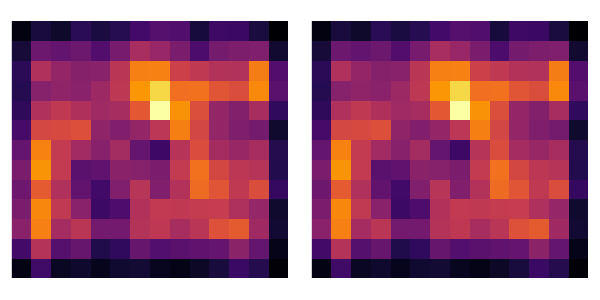

In [76]:
layer = 2
channel = 5
h1 = heatmap(CNN_model[1:layer](input)[:, :, channel, 1], background=false, legend=false, color=:inferno, aspect_ratio=:equal, axis=([], false))
h2 = heatmap(image_pass!(jump, input, cnns, layer)[:, :, channel], background=false, legend=false, color=:inferno, aspect_ratio=:equal, axis=([], false))
plot(h1, h2, layout=(1, 2), size=(600, 300))

As you can see the output of out formulation is approximately the same as the output of true layer. You can experiment with differemt value of `layer` and `channel` to ensure that the output is correct.

In [90]:
jump_model = Model(Gurobi.Optimizer)
set_silent(jump_model) # set desired parameters

cnns = get_structure(CNN_model, input);
CNN_formulate!(jump_model, CNN_model, cnns)


Set parameter Username
Academic license - for non-commercial use only - expires 2025-05-20
Formulating CNN as JuMP model...
Preprocessing completed
Added conv layer
Added meanpool layer
Added maxpool layer
Added conv layer
Added maxpool layer
Added flatten layer
Added dense layer
Added dense layer
Formulation complete.


(Dict{Int64, Dict}(0 => Dict((20, 14, 1) => 1.0, (11, 8, 1) => 1.0, (69, 8, 1) => 1.0, (65, 46, 1) => 1.0, (47, 15, 1) => 1.0, (20, 16, 1) => 1.0, (14, 12, 1) => 1.0, (24, 31, 1) => 1.0, (26, 22, 1) => 1.0, (4, 7, 1) => 1.0…), 4 => Dict((1, 2, 3) => 1.1909818861181132, (1, 3, 5) => 1.4841436383974842, (2, 5, 3) => 1.7680811302935169, (1, 4, 5) => 1.4841436383974842, (2, 1, 1) => 1.2953315250234436, (1, 3, 2) => 1.8113779673855743, (1, 4, 2) => 1.8113779673855743, (2, 2, 1) => 3.664044116994194, (1, 1, 5) => 0.6287132026416157, (1, 2, 5) => 1.4841436383974842…), 5 => Dict((1, 2, 1) => 3.664044116994194, (1, 3, 4) => 3.867979382243537, (1, 2, 5) => 3.7049730533754452, (1, 4, 4) => 3.867979382243537, (1, 3, 1) => 3.664044116994194, (1, 2, 3) => 3.428607284199104, (1, 1, 2) => 1.576238649129576, (1, 3, 5) => 3.7049730533754452, (1, 4, 1) => 3.664044116994194, (1, 4, 5) => 3.7049730533754452…), 2 => Dict((10, 1, 8) => 0.044903770089149475, (11, 8, 1) => 0.35975046269595623, (12, 1, 9) => 0.